# 6-2 DDQN
主要是基于现在的理解重新在写一个DDQN代码。

In [1]:
# import everything here ...
%load_ext autoreload
%autoreload 2
from RL_utils import *
%matplotlib inline

In [2]:
# create env
import gym
env = gym.make("CartPole-v1")
env_config = Env_Config(obdim = env.observation_space.shape[0],acdim=env.action_space.n)
config = Config(learning_rate = 0.001,env_config=env_config,  DBM=True) # 默认配置
if config.DBM:
    config.print_cfg()
set_seed(config)

--- config ---
* max_episode: 3000
* max_steps: 100
* learning_rate: 0.001
* gamma: 0.97
* epsilon: 0.1
* device: cuda
* continue_training: False
* DBM: True
* seed: 42
* tau: 0.01
* capacity: 500000.0
* warmup: 1000
* batch_size: 256
* env_config: {'obdim': 4, 'acdim': 2}
* plot_dots: 1000
* test_num: 10
------------


In [3]:
# network construction
epsilon = Epsilon(original_val=1,min_val = 0.1, liner_decay=1/2000) # use still epsilon greedy strategy
training_subject = "6-2_DDQN"
ddqn = DDQN(config=config,epsilon=epsilon)

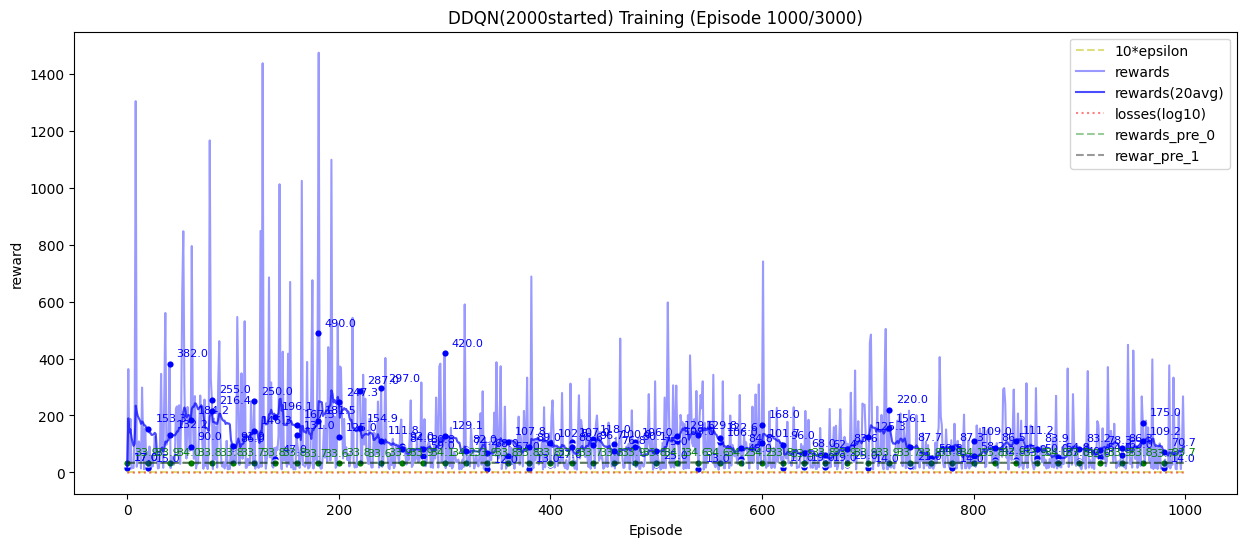

In [ ]:
# 训练模型与模型保存、replay buffer保存。
buffer = ReplayMemory_2(capacity=config.capacity)
# total means different episodes's results
total_step = 0
total_rewards = []
total_losses = []
for plot_num in range(0,(3000-1)//config.plot_dots+1):
    plot_rewards = []
    plot_losses = []
    plot_predicted_reward_left = []
    plot_predicted_reward_right = []
    plot_epsilon = []
    for episode_num in range(config.plot_dots*plot_num,config.plot_dots*(plot_num+1)):
        episode_reward = 0
        episode_losses = []
        episode_predicted_reward_left = 0
        episode_predicted_reward_right = 0
        state, _ = env.reset(seed = config.seed)
        episode_predicted_reward_left = ddqn.model(torch.from_numpy(state).to(config.device))[0].item()
        episode_predicted_reward_right = ddqn.model(torch.from_numpy(state).to(config.device))[1].item()
        plot_predicted_reward_left.append(episode_predicted_reward_left)
        plot_predicted_reward_right.append(episode_predicted_reward_right)
        plot_epsilon.append(epsilon.epsilon*10)
        done = False
        while not done:
            action = select_action(state=state, env=env, model = ddqn.model, epsilon = epsilon,config=config,device=config.device, update_epsilon=False)
            next_state, reward, done, _, _ = env.step(action = action)
            buffer.push(state=state, action=action,reward = reward, next_state=next_state,done = done)
            state = next_state
            total_step += 1
            episode_reward += reward
            epsilon.lin_update() # dont forget this one.
            if total_step > config.warmup:
                loss = ddqn.update(buffer = buffer)
                episode_losses.append(np.log10(loss))
        total_rewards.append(episode_reward)
        total_losses.append(np.mean(episode_losses) if episode_losses!=[] else 0)
        plot_rewards.append(episode_reward)
        plot_losses.append(np.mean(episode_losses) if episode_losses!=[] else 0)
        plot_rewards_20avg = [np.mean(plot_rewards[max(0, episode_num-19):episode_num+1]) for episode_num in range(len(plot_rewards))]
        draw_in_ipynb(x_s=[None,None,None,None,None,None],y_s=[plot_epsilon,plot_rewards,plot_rewards_20avg,plot_losses,plot_predicted_reward_left,plot_predicted_reward_right],alpha_s=[0.5,0.4,0.7,0.5,0.4,0.4],label_s=["10*epsilon","rewards","rewards(20avg)","losses(log10)","rewards_pre_0","rewar_pre_1"],mark_s=["y--","b-","b-","r:","g--","k--"],titletype="auto",subject=f"DDQN({plot_num*config.plot_dots}started)",config=config,save_figure=(episode_num%50==0),file_subpath=training_subject,filename=f"plot_{plot_num}.png")
        if episode_num%50 == 0:
            save_model(ddqn.model,training_subject,f"model_{episode_num}.pth")
            save_model(ddqn.target_model,training_subject,f"target_model_{episode_num}.pth")
            save_buffer(buffer,subpath=training_subject,filename="buffer.pkl")
            save_data(rewards={"rewards":total_rewards,"losses":total_losses},subpath=training_subject,filename=f"total_data.pkl")
            # test done in 123min 2.4s

In [ ]:
# test
config.DBM = False
for model_id in range(550,3000,50):
    ddqn.model.load_state_dict(torch.load(f"2model_trained/{training_subject}/model_{model_id}.pth"))
    ddqn.target_model.load_state_dict(torch.load(f"2model_trained/{training_subject}/target_model_{model_id}.pth"))
    model_rewards = []
    for i in range(config.test_num):
        # 测试，不佳seed
        state,info = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = select_action(state,env,ddqn.model,epsilon=0,config=config,device=config.device,update_epsilon=False)
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
            if total_reward >= 1000:
                break
        model_rewards.append(total_reward)
    print(f"model_id:{model_id},mean_reward:{np.mean(model_rewards)},reward_std:{np.std(model_rewards)},reward:{model_rewards}")
config.DBM = True
"""
model_id:0,mean_reward:9.1,reward_std:0.7000000000000001,reward:[10.0, 9.0, 8.0, 9.0, 10.0, 8.0, 9.0, 9.0, 9.0, 10.0]
model_id:50,mean_reward:9.3,reward_std:0.7810249675906655,reward:[10.0, 10.0, 8.0, 9.0, 11.0, 9.0, 9.0, 9.0, 9.0, 9.0]
model_id:100,mean_reward:163.1,reward_std:27.075634803269153,reward:[167.0, 176.0, 160.0, 236.0, 159.0, 157.0, 140.0, 134.0, 158.0, 144.0]
model_id:150,mean_reward:156.0,reward_std:29.46183972531247,reward:[118.0, 169.0, 134.0, 162.0, 143.0, 184.0, 214.0, 141.0, 117.0, 178.0]
model_id:200,mean_reward:144.9,reward_std:2.808914381037628,reward:[144.0, 144.0, 143.0, 140.0, 148.0, 147.0, 148.0, 142.0, 144.0, 149.0]
model_id:250,mean_reward:112.3,reward_std:4.428317965096906,reward:[117.0, 115.0, 109.0, 108.0, 104.0, 115.0, 114.0, 108.0, 118.0, 115.0]
model_id:300,mean_reward:109.5,reward_std:5.766281297335398,reward:[120.0, 106.0, 108.0, 118.0, 104.0, 104.0, 109.0, 108.0, 103.0, 115.0]
model_id:350,mean_reward:98.2,reward_std:2.3151673805580453,reward:[99.0, 96.0, 98.0, 98.0, 103.0, 99.0, 95.0, 101.0, 96.0, 97.0]
model_id:400,mean_reward:126.5,reward_std:5.6258332716140815,reward:[126.0, 133.0, 132.0, 133.0, 127.0, 133.0, 121.0, 119.0, 121.0, 120.0]
model_id:450,mean_reward:294.2,reward_std:73.3100265993677,reward:[344.0, 337.0, 326.0, 354.0, 368.0, 181.0, 183.0, 328.0, 187.0, 334.0]
model_id:500,mean_reward:157.0,reward_std:11.636150566231086,reward:[148.0, 143.0, 180.0, 154.0, 155.0, 146.0, 147.0, 173.0, 160.0, 164.0]
model_id:550,mean_reward:259.5,reward_std:251.01922237151481,reward:[171.0, 150.0, 193.0, 158.0, 170.0, 155.0, 141.0, 1000.0, 150.0, 307.0]
model_id:600,mean_reward:182.1,reward_std:39.103580398730756,reward:[172.0, 289.0, 138.0, 196.0, 169.0, 170.0, 169.0, 166.0, 196.0, 156.0]
model_id:650,mean_reward:375.1,reward_std:75.03792374526363,reward:[391.0, 359.0, 337.0, 238.0, 461.0, 325.0, 329.0, 350.0, 462.0, 499.0]
model_id:700,mean_reward:145.1,reward_std:12.32436610945975,reward:[138.0, 142.0, 132.0, 157.0, 134.0, 148.0, 162.0, 168.0, 135.0, 135.0]
model_id:750,mean_reward:286.3,reward_std:74.81316729025713,reward:[220.0, 250.0, 220.0, 319.0, 319.0, 448.0, 207.0, 354.0, 316.0, 210.0]
model_id:800,mean_reward:116.2,reward_std:4.354308211415448,reward:[115.0, 110.0, 119.0, 120.0, 113.0, 126.0, 112.0, 117.0, 115.0, 115.0]
model_id:850,mean_reward:219.1,reward_std:49.1781455526741,reward:[250.0, 193.0, 182.0, 189.0, 347.0, 172.0, 195.0, 206.0, 209.0, 248.0]
model_id:900,mean_reward:172.6,reward_std:3.2310988842807022,reward:[168.0, 170.0, 175.0, 176.0, 173.0, 173.0, 170.0, 176.0, 168.0, 177.0]
model_id:950,mean_reward:242.0,reward_std:6.752777206453653,reward:[236.0, 241.0, 240.0, 254.0, 239.0, 256.0, 235.0, 239.0, 240.0, 240.0]
model_id:1000,mean_reward:249.3,reward_std:10.01049449328054,reward:[248.0, 251.0, 243.0, 248.0, 259.0, 255.0, 229.0, 269.0, 245.0, 246.0]
model_id:1050,mean_reward:245.3,reward_std:251.58738044663528,reward:[161.0, 162.0, 156.0, 167.0, 163.0, 165.0, 1000.0, 159.0, 163.0, 157.0]
model_id:1100,mean_reward:181.6,reward_std:2.870540018881465,reward:[182.0, 184.0, 179.0, 181.0, 182.0, 181.0, 184.0, 182.0, 186.0, 175.0]
model_id:1150,mean_reward:390.6,reward_std:184.42353428995986,reward:[294.0, 653.0, 227.0, 306.0, 278.0, 288.0, 702.0, 232.0, 653.0, 273.0]
model_id:1200,mean_reward:778.7,reward_std:338.12543530471055,reward:[270.0, 243.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 274.0, 1000.0, 1000.0]
model_id:1250,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:1300,mean_reward:951.8,reward_std:144.6,reward:[1000.0, 518.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:1350,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:1400,mean_reward:546.3,reward_std:242.246589243275,reward:[351.0, 653.0, 1000.0, 424.0, 382.0, 1000.0, 370.0, 418.0, 361.0, 504.0]
model_id:1450,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:1500,mean_reward:560.9,reward_std:316.393884264535,reward:[385.0, 313.0, 268.0, 1000.0, 384.0, 1000.0, 1000.0, 730.0, 198.0, 331.0]
model_id:1550,mean_reward:304.5,reward_std:240.59561508888726,reward:[174.0, 186.0, 190.0, 181.0, 1000.0, 194.0, 390.0, 186.0, 268.0, 276.0]
model_id:1600,mean_reward:308.8,reward_std:230.40737835407964,reward:[232.0, 231.0, 235.0, 234.0, 1000.0, 233.0, 229.0, 232.0, 233.0, 229.0]
model_id:1650,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:1700,mean_reward:471.4,reward_std:335.37686264857325,reward:[144.0, 202.0, 478.0, 944.0, 994.0, 150.0, 906.0, 148.0, 502.0, 246.0]
model_id:1750,mean_reward:657.4,reward_std:419.6112963207735,reward:[1000.0, 1000.0, 144.0, 138.0, 1000.0, 140.0, 152.0, 1000.0, 1000.0, 1000.0]
model_id:1800,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:1850,mean_reward:313.2,reward_std:343.4719202496763,reward:[132.0, 150.0, 146.0, 148.0, 134.0, 1000.0, 138.0, 132.0, 152.0, 1000.0]
model_id:1900,mean_reward:858.2,reward_std:288.2255366895862,reward:[1000.0, 406.0, 1000.0, 1000.0, 1000.0, 176.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:1950,mean_reward:205.6,reward_std:35.7077022503549,reward:[200.0, 257.0, 287.0, 196.0, 168.0, 178.0, 190.0, 191.0, 179.0, 210.0]
model_id:2000,mean_reward:544.4,reward_std:264.7029278266487,reward:[332.0, 508.0, 1000.0, 320.0, 329.0, 313.0, 586.0, 736.0, 320.0, 1000.0]
model_id:2050,mean_reward:941.6,reward_std:175.2,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 416.0, 1000.0]
model_id:2100,mean_reward:651.0,reward_std:427.4622790375778,reward:[1000.0, 125.0, 1000.0, 1000.0, 125.0, 1000.0, 140.0, 1000.0, 120.0, 1000.0]
model_id:2150,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:2200,mean_reward:201.2,reward_std:266.2832326677742,reward:[1000.0, 113.0, 116.0, 113.0, 119.0, 111.0, 112.0, 110.0, 109.0, 109.0]
model_id:2250,mean_reward:286.5,reward_std:10.39471019317037,reward:[277.0, 293.0, 295.0, 299.0, 302.0, 289.0, 275.0, 274.0, 288.0, 273.0]
model_id:2300,mean_reward:759.4,reward_std:261.7629461936888,reward:[1000.0, 1000.0, 769.0, 1000.0, 508.0, 1000.0, 336.0, 556.0, 1000.0, 425.0]
model_id:2350,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:2400,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:2450,mean_reward:104.2,reward_std:3.2802438933713454,reward:[102.0, 105.0, 106.0, 107.0, 99.0, 107.0, 104.0, 108.0, 106.0, 98.0]
model_id:2500,mean_reward:145.3,reward_std:52.82622454804053,reward:[131.0, 147.0, 119.0, 152.0, 146.0, 104.0, 134.0, 296.0, 102.0, 122.0]
model_id:2550,mean_reward:126.1,reward_std:4.657252408878007,reward:[134.0, 120.0, 130.0, 127.0, 121.0, 132.0, 120.0, 125.0, 125.0, 127.0]
model_id:2600,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:2650,mean_reward:149.1,reward_std:11.869709347747316,reward:[144.0, 144.0, 136.0, 153.0, 159.0, 156.0, 137.0, 131.0, 168.0, 163.0]
model_id:2700,mean_reward:660.5,reward_std:415.8149227721391,reward:[155.0, 145.0, 1000.0, 1000.0, 1000.0, 1000.0, 158.0, 1000.0, 147.0, 1000.0]
model_id:2750,mean_reward:456.6,reward_std:356.77505518183307,reward:[163.0, 233.0, 1000.0, 236.0, 187.0, 1000.0, 246.0, 1000.0, 241.0, 260.0]
model_id:2800,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:2850,mean_reward:848.2,reward_std:311.8159072273254,reward:[1000.0, 1000.0, 82.0, 1000.0, 1000.0, 400.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:2900,mean_reward:1000.0,reward_std:0.0,reward:[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
model_id:2950,mean_reward:123.0,reward_std:10.89954127475097,reward:[137.0, 106.0, 122.0, 112.0, 118.0, 124.0, 138.0, 139.0, 118.0, 116.0]
"""

model_id:550,mean_reward:259.5,reward_std:251.01922237151481,reward:[171.0, 150.0, 193.0, 158.0, 170.0, 155.0, 141.0, 1000.0, 150.0, 307.0]
model_id:600,mean_reward:182.1,reward_std:39.103580398730756,reward:[172.0, 289.0, 138.0, 196.0, 169.0, 170.0, 169.0, 166.0, 196.0, 156.0]
model_id:650,mean_reward:375.1,reward_std:75.03792374526363,reward:[391.0, 359.0, 337.0, 238.0, 461.0, 325.0, 329.0, 350.0, 462.0, 499.0]
model_id:700,mean_reward:145.1,reward_std:12.32436610945975,reward:[138.0, 142.0, 132.0, 157.0, 134.0, 148.0, 162.0, 168.0, 135.0, 135.0]
model_id:750,mean_reward:286.3,reward_std:74.81316729025713,reward:[220.0, 250.0, 220.0, 319.0, 319.0, 448.0, 207.0, 354.0, 316.0, 210.0]
model_id:800,mean_reward:116.2,reward_std:4.354308211415448,reward:[115.0, 110.0, 119.0, 120.0, 113.0, 126.0, 112.0, 117.0, 115.0, 115.0]
model_id:850,mean_reward:219.1,reward_std:49.1781455526741,reward:[250.0, 193.0, 182.0, 189.0, 347.0, 172.0, 195.0, 206.0, 209.0, 248.0]
model_id:900,mean_reward:172.6,r

'\nmodel_id:0,mean_reward:9.1,reward_std:0.7000000000000001,reward:[10.0, 9.0, 8.0, 9.0, 10.0, 8.0, 9.0, 9.0, 9.0, 10.0]\nmodel_id:50,mean_reward:9.3,reward_std:0.7810249675906655,reward:[10.0, 10.0, 8.0, 9.0, 11.0, 9.0, 9.0, 9.0, 9.0, 9.0]\nmodel_id:100,mean_reward:163.1,reward_std:27.075634803269153,reward:[167.0, 176.0, 160.0, 236.0, 159.0, 157.0, 140.0, 134.0, 158.0, 144.0]\nmodel_id:150,mean_reward:156.0,reward_std:29.46183972531247,reward:[118.0, 169.0, 134.0, 162.0, 143.0, 184.0, 214.0, 141.0, 117.0, 178.0]\nmodel_id:200,mean_reward:144.9,reward_std:2.808914381037628,reward:[144.0, 144.0, 143.0, 140.0, 148.0, 147.0, 148.0, 142.0, 144.0, 149.0]\nmodel_id:250,mean_reward:112.3,reward_std:4.428317965096906,reward:[117.0, 115.0, 109.0, 108.0, 104.0, 115.0, 114.0, 108.0, 118.0, 115.0]\nmodel_id:300,mean_reward:109.5,reward_std:5.766281297335398,reward:[120.0, 106.0, 108.0, 118.0, 104.0, 104.0, 109.0, 108.0, 103.0, 115.0]\nmodel_id:350,mean_reward:98.2,reward_std:2.3151673805580453,re